In [ ]:
import random
import math
import matplotlib.pyplot as plt


BOUNDS = (0, 100, 0, 60)

NUM_OBS = 20          
RADIUS  = 4          

MARGIN_FROM_POINTS = 6.0


MIN_GAP_BETWEEN_OBS = 1.0  
BORDER_GAP          = 0.0   


MAX_TRIES = 50_000
SEED = None  
if SEED is not None:
    random.seed(SEED)


EPS = 1.0
PAD = 1.0


INICIO = (BOUNDS[0] + EPS, BOUNDS[3] - EPS) 
FIM  = (BOUNDS[1] - EPS, BOUNDS[2] + EPS)  

print("Configuração carregada.")

Configuração carregada.


In [82]:
def dist(a, b):
    
    return math.hypot(a[0] - b[0], a[1] - b[1])

def inside_bounds(center, r, bounds, border_gap=0.0):
   
    x, y = center
    min_x, max_x, min_y, max_y = bounds
    return (x - r - border_gap) >= min_x and (x + r + border_gap) <= max_x \
       and (y - r - border_gap) >= min_y and (y + r + border_gap) <= max_y

def valid_center(candidate, centers, r, bounds, start, goal,
                 clearance_pts, min_gap_between_obs=0.0, border_gap=0.0):
    
    if not inside_bounds(candidate, r, bounds, border_gap):
        return False

  
    min_center_dist = 2*r + min_gap_between_obs
    for c in centers:
        if dist(candidate, c) < min_center_dist:
            return False

    extra = 0.5 * min_gap_between_obs
    if dist(candidate, start) < (r + clearance_pts + extra):
        return False
    if dist(candidate, goal) < (r + clearance_pts + extra):
        return False

    return True

def generate_random_centers(n, r, bounds, inicio, fim,
                            clearance_pts, min_gap_between_obs=0.0,
                            border_gap=0.0, max_tries=10000):
    
    min_x, max_x, min_y, max_y = bounds
    centers, tries = [], 0

    lo_x, hi_x = min_x + r + border_gap, max_x - r - border_gap
    lo_y, hi_y = min_y + r + border_gap, max_y - r - border_gap
    if lo_x > hi_x or lo_y > hi_y:
        raise ValueError("Mapa pequeno demais para o raio/gaps escolhidos.")

    while len(centers) < n and tries < max_tries:
        tries += 1
        cand = (random.uniform(lo_x, hi_x), random.uniform(lo_y, hi_y))
        if valid_center(cand, centers, r, bounds, inicio, fim,
                        clearance_pts, min_gap_between_obs, border_gap):
            centers.append(cand)

    if len(centers) < n:
        raise RuntimeError(
            f"Não foi possível posicionar {n} círculos após {max_tries} tentativas. "
            "Reduza NUM_OBS/RADIUS/MARGIN_FROM_POINTS/MIN_GAP_BETWEEN_OBS ou aumente o mapa."
        )
    return centers



In [83]:
def plot_map_and_points(bounds, Inicio, Fim, title):
   
    min_x, max_x, min_y, max_y = bounds
    fig, ax = plt.subplots()
    ax.set_title(title)

 
    ax.set_xlim(min_x - PAD, max_x + PAD)
    ax.set_ylim(min_y - PAD, max_y + PAD)
    ax.set_aspect('equal', adjustable='box')
    ax.autoscale(False) 

    ax.grid(True)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")



    # pontos: mesmo marcador e tamanho; cores diferentes
    ax.scatter([Inicio[0]], [Inicio[1]], marker='o', s=80, label='Início',
               color='tab:blue', zorder=3)
    ax.scatter([Fim[0]],  [Fim[1]],  marker='o', s=80, label='Fim',
               color='tab:orange', zorder=3)

    ax.legend(loc='best')

def plot_obstacles(centers, r):
    """Desenha os círculos (obstáculos) já com o Axes atual."""
    ax = plt.gca()
    for c in centers:
        ax.add_patch(plt.Circle(c, r, fill=False))  # só contorno

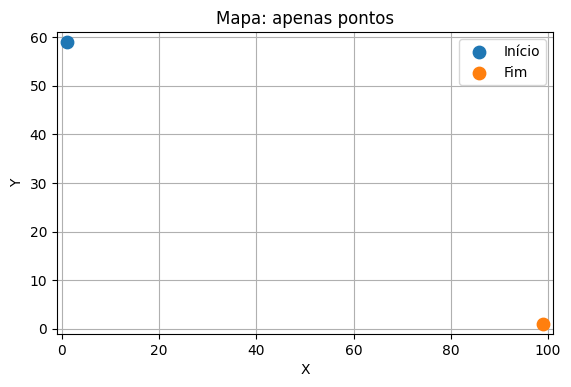

In [84]:
total_clearance = RADIUS + MARGIN_FROM_POINTS


plot_map_and_points(BOUNDS, INICIO, FIM, "Mapa: apenas pontos")
plt.show()

20 centros gerados.


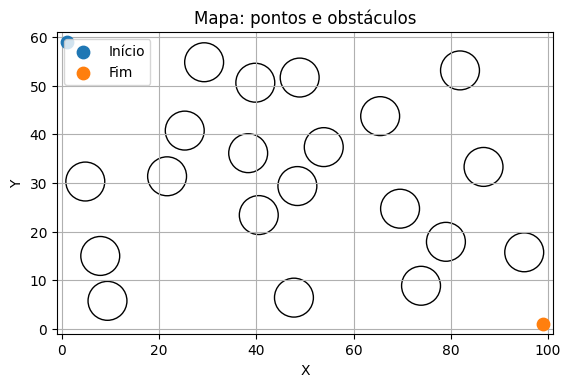

In [87]:
centers = generate_random_centers(
    NUM_OBS, RADIUS, BOUNDS, INICIO, FIM,
    total_clearance,
    min_gap_between_obs=MIN_GAP_BETWEEN_OBS,
    border_gap=BORDER_GAP,
    max_tries=MAX_TRIES
)
print(f"{len(centers)} centros gerados.")
plot_map_and_points(BOUNDS, INICIO, FIM, "Mapa: pontos e obstáculos")
plot_obstacles(centers, RADIUS)
plt.show()